In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

2022-02-05 15:24:49.985311: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 15:24:50.016269: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-05 15:24:50.018455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


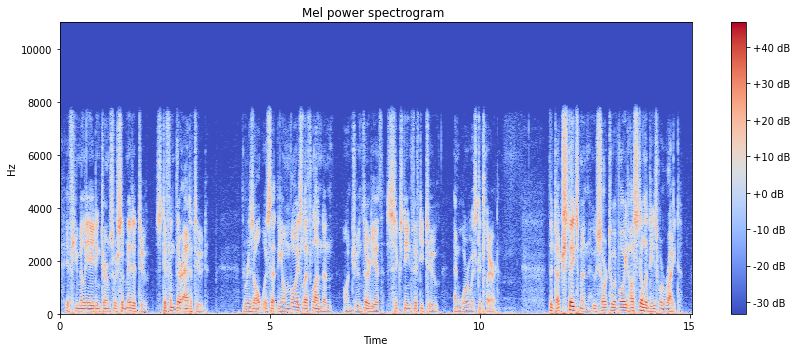

In [5]:
audio_data = './vad_data/1081-125237-0033.wav' #'recorded.wav'
signal , sr = librosa.load(audio_data)
start = 0
end = len(signal)//sr
seg_star = int(np.floor(start * sr))
seg_end = int(np.floor(end * sr))
ipd.Audio(data=signal[seg_star:seg_end], rate=sr)


X = librosa.stft(signal.astype('float'))
Xdb = librosa.amplitude_to_db(X)
plt.figure(figsize=(12, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [6]:
def extract_features(signal, sr=16000, n_mfcc=5, size=512, step=16, n_mels=40):
    mfcc = librosa.feature.mfcc(signal, sr=sr, n_mfcc=n_mfcc, n_fft=size, hop_length=step)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)

    mel_spectogram = librosa.feature.melspectrogram(signal, sr=sr, n_mels=n_mels, n_fft=size, hop_length=step)
    rmse = librosa.feature.rms(S=mel_spectogram, frame_length=n_mels * 2 - 1, hop_length=step)

    mfcc, mfcc_delta, mfcc_delta_2, rmse = np.asarray(mfcc), np.asarray(mfcc_delta), np.asarray(mfcc_delta_2), np.asarray(rmse)
    # print(mfcc.shape, mfcc_delta.shape, mfcc_delta_2.shape, rmse.shape)
    features = np.concatenate((mfcc, mfcc_delta, mfcc_delta_2, rmse), axis=0)
    return features.transpose()

nbseg = (seg_end - seg_star)//1024
print(nbseg)
data = []
start = seg_star
end = start + 1024
segs = []
for seg in range(nbseg):
    segs.append([start, end])
    data.append(extract_features(signal[start:end]))
    start += 1024
    end += 1024
data = np.asarray(data)
data.shape

322


(322, 65, 16)

In [8]:
import tensorflow as tf
import keras_resnet.models

# model = tf.keras.models.load_model('tuan.h5')
# model.summary()

shape, classes = (65, 16, 1), 2
# x = tf.keras.layers.Input(shape)
# model = keras_resnet.models.ResNet18(x, classes=classes)
# model.load_weights('lstm.h5')
model = tf.keras.models.load_model('./models/cnn.h5')

In [10]:
predict = model.predict(data.reshape(data.shape[0], 65, 16, 1))
# predict = model.predict(data)
predict = np.argmax(predict, axis=1)
print(predict)

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]


In [27]:
print(len(predict))

86


In [28]:
label = np.load('train_labels.npy')
print(len(label))
print(label.sum())

164068
132803


In [12]:
132803/164068

0.8094387692907818

In [13]:
label = np.load('./train_labels.npy')
tf.keras.utils.to_categorical(label).shape

(164068, 2)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

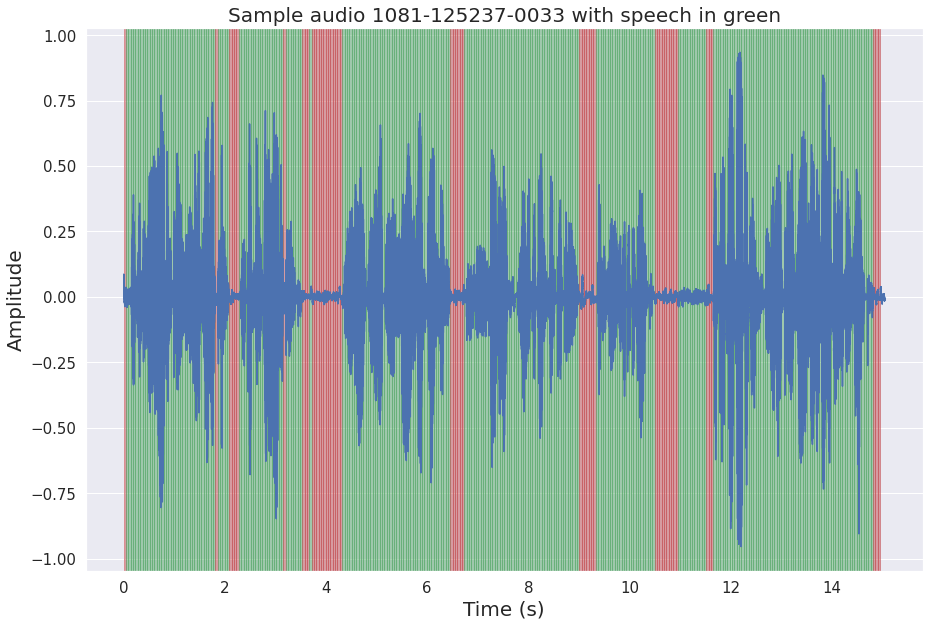

In [18]:
plt.figure(figsize=(15, 10))
sns.set()
sns.lineplot(x=[i / sr for i in range(len(signal))], y=signal)

start, end = 0, 0
for i, seg in enumerate(segs):
    start, end = seg[0] / sr, seg[1] / sr
    color = 'r' if predict[i]==0 else 'g'
    plt.axvspan(start, end, alpha=0.5, color=color)

plt.title(f"Sample audio 1081-125237-0033 with speech in green", size=20)
plt.xlabel("Time (s)", size=20)
plt.ylabel("Amplitude", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.savefig('sample.png', dpi=300)
plt.show()